# Basics

## Import Libraries

In [30]:
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2.6.0


In [45]:
## For plotting
script_path=os.environ.get('DirForPoolScripts')
sys.path.append(script_path)

## Download Dataset

In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

2021-12-16 09:01:17.143004: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
print(type(imdb),"\n",imdb,'\n',info) 

<class 'dict'> 
 {'train': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>, 'test': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>, 'unsupervised': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>} 
 tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='/Users/psaxena/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dty

# Data Preproccesing
1.  we need to convert PrefetechDataset to numpy, in order to do further preprocessing with text data

In [16]:
train_data, test_data = imdb['train'], imdb['test']
print(f"type of datasets is {type(train_data)} \n {train_data} \n {test_data}")

type of datasets is <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'> 
 <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)> 
 <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>


In [21]:
## A Peek into the dataset
for s, l in list(train_data)[0:2]:
    print(s, l)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on t

In [28]:
## Lets save the sentences in list and labels in ndarray
training_sentences = []
training_labels    = []
testing_sentences  = []
testing_labels     = []

for s,l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())

for s,l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels) ## numpy arrray
testing_labels_final = np.array(testing_labels)   ## numpy array

## Initiating Tokenzier

In [38]:
vocab_size    = 10000   ## We are interested in 10k unique vacobalary size
embedding_dim = 16      ## We expect 16 dim cluster of differnt unique words
max_length    = 120     ## for a sentence to contain unique words 
trunc_type    = 'post'  ## post truncate, if sentence contain more than 120 words
oov_tok       = "<OOV>" ## usual Out-of-Vocablory token

tokenizer     = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index       = tokenizer.word_index
sequences        = tokenizer.texts_to_sequences(training_sentences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences        = tokenizer.texts_to_sequences(testing_sentences)
testing_padded_sequences = pad_sequences(testing_sequences, maxlen=max_length)

## Reverse value:key to key:value

In [35]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[4]))
print(training_sentences[5])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? as others have mentioned all the women that go nude in this film are mostly absolutely gorgeous the plot very <OOV> shows the <OOV> of the female <OOV> when men are around they want to be pursued but when no men are around they become the <OOV> of a 14 year old boy and the boy becomes a man really fast we should all be so lucky at this age he then gets up the courage to pursue his true love
This is a film which should be seen by anybody interested in, effected by, or suffering from an eating disorder. It is an amazingly accurate and sensitive portrayal of bulimia in a teenage girl, its causes and its symptoms. The girl is played by one of the most brilliant young actresses working in cinema today, Alison Lohman, who was later so spectacular in 'Where the Truth Lies'. I would recommend that this film be shown in all schools, as you will never see a better on this subject. Alison Lohman is absolutely outstandin

# Modelling

## Model Definition

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), 
    tf.keras.layers.GlobalAveragePooling1D(), ##tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


## Training

In [50]:
num_epochs = 10
history=model.fit(padded_sequences, 
                  training_labels_final, 
                  epochs=num_epochs, 
                  validation_data=(testing_padded_sequences, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 2s 2ms/step - loss: 0.0195 - accuracy: 0.9960 - val_loss: 1.6222 - val_accuracy: 0.7861
Epoch 2/10
782/782 [==============================] - 2s 2ms/step - loss: 0.0191 - accuracy: 0.9954 - val_loss: 1.7311 - val_accuracy: 0.7888
Epoch 3/10
782/782 [==============================] - 2s 2ms/step - loss: 0.0188 - accuracy: 0.9952 - val_loss: 1.8041 - val_accuracy: 0.7891
Epoch 4/10
782/782 [==============================] - 2s 3ms/step - loss: 0.0176 - accuracy: 0.9951 - val_loss: 1.8772 - val_accuracy: 0.7892
Epoch 5/10
782/782 [==============================] - 1s 2ms/step - loss: 0.0145 - accuracy: 0.9961 - val_loss: 1.8935 - val_accuracy: 0.7880
Epoch 6/10
782/782 [==============================] - 1s 2ms/step - loss: 0.0114 - accuracy: 0.9969 - val_loss: 1.9519 - val_accuracy: 0.7866
Epoch 7/10
782/782 [==============================] - 1s 2ms/step - loss: 0.0107 - accuracy: 0.9966 - val_loss: 2.0740 - val_accuracy: 0.7882
Epoch 

## Plotting

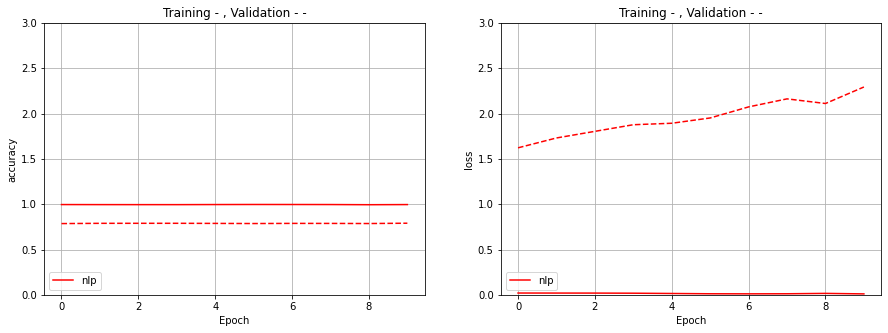

In [53]:
from ploting_script import plot_n_model 
plot_n_model(num_history=1, name_history=[history], label_list=["nlp"], ylim_low=0, ylim_high=3)

## We are overfitting here

## Look on Embeddling

In [54]:
## Lets extract the embeding & weight for layer-0
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


## Visualization
1. Save words, embedding as vecs.tsv and meta.tsv file
2. Visualize these vector & metadata in https://projector.tensorflow.org

In [57]:
## lets write the vector on embedded data on file
## tensorflow Projector read .tsv file to plot them to 3D space for visualization

import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
    
    word       = reverse_word_index[word_num]
    embeddings = weights[word_num]
    
    out_m.write(word + "\n") ## metadata array
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()

In [14]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download('vecs.tsv')
    files.download('meta.tsv')

In [62]:
sentence = "I really think this is cool. honest."
sequence = tokenizer.texts_to_sequences([sentence])
print(sequence)

[[11, 64, 102, 12, 7, 645, 1200]]
